In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem

from cpsplines.mosek_functions.interval_constraints import IntConstraints
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.gcv import GCV
import statsmodels.genmod.families.family
import mosek.fusion as mf

from Functions import poly

from Functions import simpleGCV
from Functions import choose_lambda
from Functions import simpson_spline_full
from Functions import simpson_spline_matrices
from Functions import intGCV
from Functions import choose_lambda_int
from Functions import create_obj_mat
from Functions import unconstrained_sof_fit
from Functions import cp_sof_fit
import time
from scipy.stats import norm
from scipy.stats import pareto

In [2]:

#ESTO PARA NUESTRO PROBLEMA

alpha = 0.15
#Trabajaremos con estos datos
m = 50
T = np.linspace(0.00, 1, num=m)

T2 = np.linspace(0.00, 1, num=501)

# betaT = beta(T)
#weights. 1/3 for the limits, 2/3 for the odd subintervals, 4/3 for the even ones. 

w = [1/3] + [4/3 if i%2==0 else 2/3 for i in range(2,501)] + [1/3]
W = 1/501* np.diag(w)


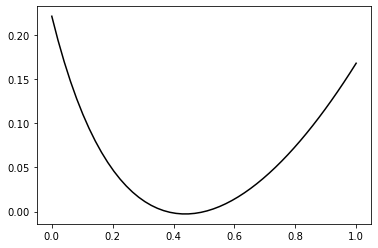

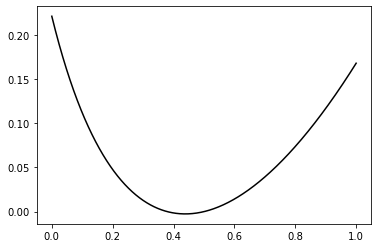

In [3]:

betaT=pd.read_csv("betaT_conv.csv", header=None )
betaT=np.array(betaT).squeeze()
betaT2=pd.read_csv("betaT2_conv.csv", header=None )
betaT2=np.array(betaT2).squeeze()

plt.plot(T,betaT, 'k-')
plt.show()
plt.plot(T2,betaT2, 'k-')
plt.show()

## ERROR SIGUE UNA $N(0, 0.01)$

### Gráficos

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 7

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_conv001', str(i+1), str(N)])
        tttt="_".join(['y_conv001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None)
        y = pd.read_csv("".join([tttt,'.csv']), header=None)
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        #plt.figure(figsize=(3,4))
        #plt.plot(T2, betaT2, label = 'True beta')
        #plt.plot(T2,betagorro, label=f'approx {i+1}')
        #plt.axhline(0, color='red')
        #plt.ylim([0.0, 1])
        #plt.legend()
        #plt.show()
        #plt.figure(figsize=(3,4))
        #plt.plot(np.linspace(0,1, num=len(y)), y, label = 'True y')
        #plt.plot(np.linspace(0,1, num=len(y_hat)), y_hat, label=f'approx {i+1}')
        #plt.axhline(0, color='red')
        #plt.ylim([0.05, 0.3])
        #plt.legend()
        #plt.show()
        ## Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE.sum()/n_sims*1000)
    print(sem(IMSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Cálculo del IMSE y del MSE

IMSE for N= 35 0.45612552262475337
MSE for N= 35 0.12127504810092653
Standard deviation of the IMSE: 2.4689399841985395e-05
Standard deviation of the MSE: 4.4631984224850605e-06
7.192359983872671e-05
IMSE for N= 75 0.37945622673150764
MSE for N= 75 0.1292260243182165
Standard deviation of the IMSE: 8.631247849458389e-06
Standard deviation of the MSE: 1.3965952196232477e-06
7.192359983872671e-05
IMSE for N= 125 0.3923901761849169
MSE for N= 125 0.12917531528301132
Standard deviation of the IMSE: 6.906681414712755e-06
Standard deviation of the MSE: 1.1010814610742864e-06
7.192359983872671e-05


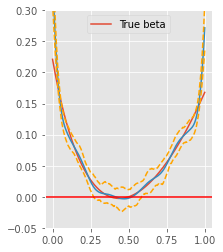

Times [ 84.23824906 156.04132199 214.5810709 ]


In [60]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons001=np.zeros(n_sims)
MSE_uncons001=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    for i in range(n_sims):
        ssss="_".join(['X_conv001', str(i+1), str(N)])
        tttt="_".join(['y_conv001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
        # plt.figure()
        # plt.plot(T,betaT)
        # plt.plot(T2, betagorro)
        # plt.show()
        #IMSE
        IMSE_uncons001[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_uncons001[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons001.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons001.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons001))
    print('Standard deviation of the MSE:', sem(MSE_uncons001))
    print(sem(IMSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

## ERROR SIGUE UNA $N(0, 0.05)$

IMSE for N= 35 1.5845323447669857
MSE for N= 35 2.1734393241008236
Standard deviation of the IMSE: 0.000112280631846744
Standard deviation of the MSE: 4.6405219789941435e-05
7.192359983872671e-05
IMSE for N= 75 0.9332501904319792
MSE for N= 75 2.327169781353468
Standard deviation of the IMSE: 7.505234111697187e-05
Standard deviation of the MSE: 3.128951919260133e-05
7.192359983872671e-05
IMSE for N= 125 0.7751549394575935
MSE for N= 125 2.4170713368453587
Standard deviation of the IMSE: 5.920909013799274e-05
Standard deviation of the MSE: 2.459284558107084e-05
7.192359983872671e-05


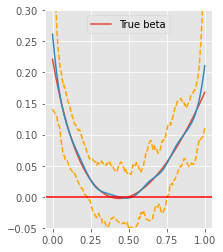

Times [ 89.83622909 153.72891641 230.4083426 ]


In [62]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons005=np.zeros(n_sims)
MSE_uncons005=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_conv005', str(i+1), str(N)])
        tttt="_".join(['y_conv005', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons005[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_uncons005[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons005.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons005.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons005))
    print('Standard deviation of the MSE:', sem(MSE_uncons005))
    print(sem(IMSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

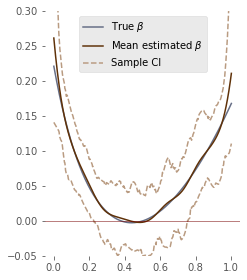

In [63]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend(loc='upper center')
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_convexuncons005.png', transparent=True)
plt.show()

## CONSTRAINED: ERROR SIGUE UNA $N(0, 0.01)$

### Plots

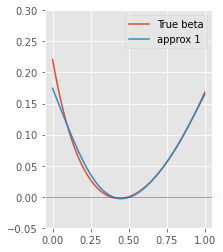

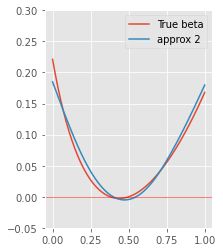

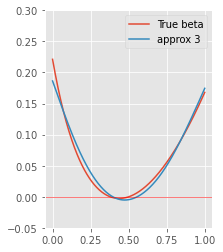

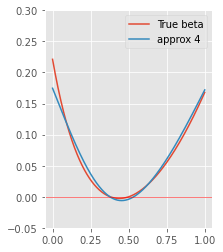

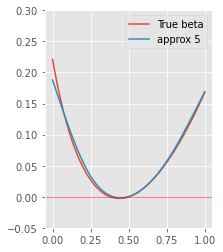

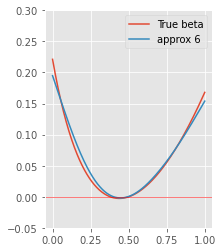

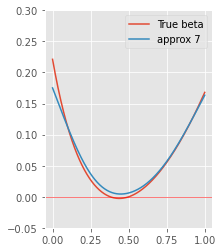

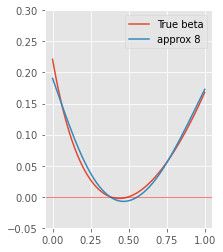

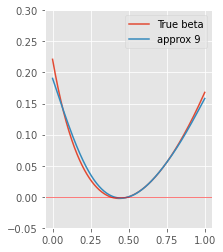

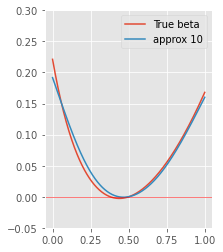

IMSE for N= 125 0.06656969963393604
MSE for N= 125 0.3009520581858208
Standard deviation of the IMSE: 5.921481339243071e-06
Standard deviation of the MSE: 1.2064531095600881e-05


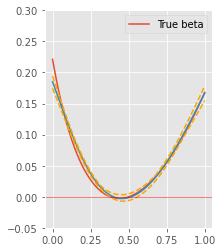

Times [16.33185959  0.          0.        ]


In [64]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 10

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_conv001', str(i+1), str(N)])
        tttt="_".join(['y_conv001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=2, sign='+', sign_threshold=0.0,  plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red', linewidth=0.5)
        plt.ylim([-0.05, 0.3])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

### Cálculo del IMSE y del MSE

IMSE for N= 35 0.2745966685014006
MSE for N= 35 0.22181192947952505
Standard deviation of the IMSE: 1.4792721454845314e-05
Standard deviation of the MSE: 5.421627196692916e-06
IMSE for N= 75 0.12265239054601275
MSE for N= 75 0.30618104298436066
Standard deviation of the IMSE: 3.255325450586192e-06
Standard deviation of the MSE: 3.533412126918078e-06
IMSE for N= 125 0.07315823893197576
MSE for N= 125 0.2970226180885629
Standard deviation of the IMSE: 1.7520114983499884e-06
Standard deviation of the MSE: 2.690189634348795e-06


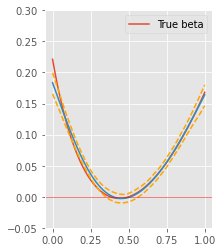

Times [122.12938333 191.16747165 309.24764657]


In [65]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_cons001=np.zeros(n_sims)
MSE_cons001=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_conv001', str(i+1), str(N)])
        tttt="_".join(['y_conv001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=2, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons001[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons001[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons001.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons001.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons001))
    print('Standard deviation of the MSE:', sem(MSE_cons001))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_cons001=np.zeros(n_sims)
MSE_cons001=np.zeros(n_sims)

cont=0
for N in [35,75,125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_conv001', str(i+1), str(N)])
        tttt="_".join(['y_conv001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=2, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons001[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons001[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons001.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons001.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons001))
    print('Standard deviation of the MSE:', sem(MSE_cons001))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

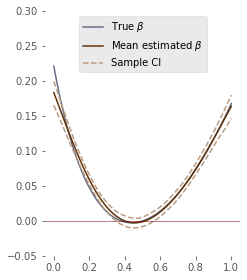

In [9]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend(loc='upper center')
plt.style.use('ggplot')
plt.box(False)
plt.savefig('paretoconvex_cons_001.png', transparent=True)
plt.show()

### CONSTRAINED: ERROR SIGUE UNA $N(0, 0.05)$

IMSE for N= 35 1.081343325341824
MSE for N= 35 2.3143723571693413
Standard deviation of the IMSE: 6.223829788458448e-05
Standard deviation of the MSE: 4.332152854071503e-05
IMSE for N= 75 0.4352456168653689
MSE for N= 75 2.5220911031537385
Standard deviation of the IMSE: 2.0921407209903626e-05
Standard deviation of the MSE: 2.929442082991333e-05
IMSE for N= 125 0.2519385051432226
MSE for N= 125 2.6214477720802183
Standard deviation of the IMSE: 1.211882945912779e-05
Standard deviation of the MSE: 2.4242947840135744e-05


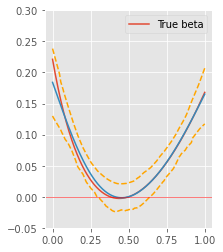

Times [106.5971632  190.31032181 308.2994802 ]


In [67]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_constrained = np.zeros(3)

IMSE_cons005=np.zeros(n_sims)
MSE_cons005=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_conv005', str(i+1), str(N)])
        tttt="_".join(['y_conv005', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=2, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons005[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons005[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons005.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons005.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons005))
    print('Standard deviation of the MSE:', sem(MSE_cons005))
    end_time = time.time()
    time_constrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend()
plt.show()
print('Times', time_constrained)

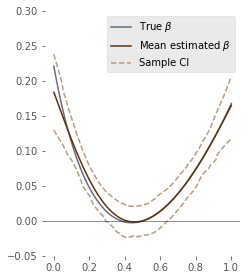

In [69]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.05, 0.3])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('paretoconvex_cons_005.png', transparent=True)
plt.show()